# Notes for user:

*   This notebook will use the dataset COVID-19 and forex to predict the forex spot price of a currency pair.
*   What to ask user before using this application:
*   What currency pair are you interested in? GBP/USD (This layout means that the base currency is USD)
*   The currency the user wants to look at is how much the USD is worth to the GBP.
*   Therefore, we look at the death rates in the US and the UK.
*   LSTMs are good at looking at changed over time. We need to also consider that what happen more recently is a better judgement than what happened a long time ago. This is why CNNs might be interesting to explore.


In [270]:
# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8_805zx2
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-8_805zx2
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0670b7525ad6102d455fb36f49c819d83edd49f5c_-cp36-none-any.whl size=126665 sha256=2e6659caaf8b01ebd30a1d3f3deeea939dbc3eea899e59d2bf45c32f865be13a
  Stored in directory: /tmp/pip-ephem-wheel-cache-6sywhtf8/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [271]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [272]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.3.0


In [273]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling



In [274]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Data Collection


In [275]:
# Importing covid_dataset using pandas. Droping null values.
covid_dataset_data= pd.read_csv('owid_covid_data.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
# covid_dataset = covid_dataset.dropna()
covid_dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,0.0,0.0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.0,0.0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.33,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-24,12.0,8.0,0.0,0.0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
3,ABW,North America,Aruba,2020-03-25,17.0,5.0,0.0,0.0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
4,ABW,North America,Aruba,2020-03-26,19.0,2.0,0.0,0.0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.44,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [276]:
# Trying to isolate location/country based on currency in question
# We are looking at pound and sterling therefore need to isolate 'United Kingdom' & 'United States' in location column
us_death_rates = covid_dataset.loc[covid_dataset.location=='United States', ['location', 'date', 'total_cases', 'total_deaths']]
us_death_rates.head()

,location,date,total_cases,total_deaths
32403,United States,2019-12-31,0.0,0.0
32404,United States,2020-01-01,0.0,0.0
32405,United States,2020-01-02,0.0,0.0
32406,United States,2020-01-03,0.0,0.0
32407,United States,2020-01-04,0.0,0.0


In [277]:
# us_death_rates = covid_dataset.loc[covid_dataset.location=='Zimbabwe', ['location', 'date', 'total_deaths','total_cases','cvd_death_rate']]
# us_death_rates.head()

In [278]:
us_death_rates.shape

(218, 4)

In [279]:
# Import forex
forex_dataset_data= pd.read_csv('investing.com.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
# forex_dataset = forex_dataset_data.dropna()


# Data Preprocessing / Data Cleaning & Collating

In [280]:
# Filter dataset
forex_dataset.pop('Open')
forex_dataset.pop('High')
forex_dataset.pop('Low')
forex_dataset.pop('Change %')

0      -0.04%
1       0.76%
2       0.49%
3       0.38%
4       0.72%
        ...  
149     0.62%
150    -0.44%
151    -0.82%
152    -0.05%
153     1.11%
Name: Change %, Length: 154, dtype: object

In [281]:
forex_dataset.tail()

,Date,Price
149,"Jan 06, 2020",1.3169
150,"Jan 03, 2020",1.3088
151,"Jan 02, 2020",1.3146
152,"Jan 01, 2020",1.3255
153,"Dec 31, 2019",1.3261


In [282]:
# Isolate covid_date
import time 
us_date = us_death_rates['date']
new_us_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in us_date]
us_death_rates['date'] = new_us_dates
us_death_rates.head()


,location,date,total_cases,total_deaths
32403,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0
32404,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0
32405,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0
32406,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0
32407,United States,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",0.0,0.0


In [283]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()


,Date,Price
149,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",1.3169
150,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088
151,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146
152,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255
153,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261


In [284]:
print(len(forex_dataset))

154


In [285]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='date')
dataset.tail()
len(dataset)


154

In [286]:
# We pop the 'date' from the covid_dataset because this column starts later than the forex column
# We want to see the forex price before covid happened
dataset.pop('date')

0       (2020, 7, 31, 0, 0, 0, 4, 213, -1)
1       (2020, 7, 30, 0, 0, 0, 3, 212, -1)
2       (2020, 7, 29, 0, 0, 0, 2, 211, -1)
3       (2020, 7, 28, 0, 0, 0, 1, 210, -1)
4       (2020, 7, 27, 0, 0, 0, 0, 209, -1)
                      ...                 
149        (2020, 1, 6, 0, 0, 0, 0, 6, -1)
150        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
151        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
152        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
153    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: date, Length: 154, dtype: object

In [287]:
# Problem: 	(2020, 7, 31) when head
dataset.head()

,Date,Price,location,total_cases,total_deaths
0,"(2020, 7, 31, 0, 0, 0, 4, 213, -1)",1.3090,United States,4495014.0,152070.0
1,"(2020, 7, 30, 0, 0, 0, 3, 212, -1)",1.3095,United States,4426982.0,150713.0
2,"(2020, 7, 29, 0, 0, 0, 2, 211, -1)",1.2996,United States,4351997.0,149256.0
3,"(2020, 7, 28, 0, 0, 0, 1, 210, -1)",1.2932,United States,4290263.0,148011.0
4,"(2020, 7, 27, 0, 0, 0, 0, 209, -1)",1.2882,United States,4234020.0,146935.0


In [288]:
dataset.tail()

,Date,Price,location,total_cases,total_deaths
149,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",1.3169,United States,0.0,0.0
150,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088,United States,0.0,0.0
151,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146,United States,0.0,0.0
152,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255,United States,0.0,0.0
153,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261,United States,0.0,0.0


In [289]:
# View what date looks like
date = dataset['Date']
date.head()

0    (2020, 7, 31, 0, 0, 0, 4, 213, -1)
1    (2020, 7, 30, 0, 0, 0, 3, 212, -1)
2    (2020, 7, 29, 0, 0, 0, 2, 211, -1)
3    (2020, 7, 28, 0, 0, 0, 1, 210, -1)
4    (2020, 7, 27, 0, 0, 0, 0, 209, -1)
Name: Date, dtype: object

In [290]:
# Splitting timestamp and isolating the date
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
print(dateFormatting)


                         new_date
0   2019-12-31 00:00:00.000000000
1   2020-01-01 09:24:42.352941176
2   2020-01-02 18:49:24.705882352
3   2020-01-04 04:14:07.058823529
4   2020-01-05 13:38:49.411764705
..                            ...
149 2020-07-25 10:21:10.588235294
150 2020-07-26 19:45:52.941176472
151 2020-07-28 05:10:35.294117648
152 2020-07-29 14:35:17.647058824
153 2020-07-31 00:00:00.000000000

[154 rows x 1 columns]


In [291]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
print(my_xticks)

[Timestamp('2019-12-31 00:00:00'), Timestamp('2020-01-01 09:24:42.352941176'), Timestamp('2020-01-02 18:49:24.705882352'), Timestamp('2020-01-04 04:14:07.058823529'), Timestamp('2020-01-05 13:38:49.411764705'), Timestamp('2020-01-06 23:03:31.764705882'), Timestamp('2020-01-08 08:28:14.117647058'), Timestamp('2020-01-09 17:52:56.470588235'), Timestamp('2020-01-11 03:17:38.823529411'), Timestamp('2020-01-12 12:42:21.176470588'), Timestamp('2020-01-13 22:07:03.529411764'), Timestamp('2020-01-15 07:31:45.882352941'), Timestamp('2020-01-16 16:56:28.235294117'), Timestamp('2020-01-18 02:21:10.588235294'), Timestamp('2020-01-19 11:45:52.941176470'), Timestamp('2020-01-20 21:10:35.294117647'), Timestamp('2020-01-22 06:35:17.647058823'), Timestamp('2020-01-23 16:00:00'), Timestamp('2020-01-25 01:24:42.352941176'), Timestamp('2020-01-26 10:49:24.705882353'), Timestamp('2020-01-27 20:14:07.058823529'), Timestamp('2020-01-29 05:38:49.411764706'), Timestamp('2020-01-30 15:03:31.764705882'), Timesta

In [292]:
dataset['Date'] # 2020, 7, 31

0       (2020, 7, 31, 0, 0, 0, 4, 213, -1)
1       (2020, 7, 30, 0, 0, 0, 3, 212, -1)
2       (2020, 7, 29, 0, 0, 0, 2, 211, -1)
3       (2020, 7, 28, 0, 0, 0, 1, 210, -1)
4       (2020, 7, 27, 0, 0, 0, 0, 209, -1)
                      ...                 
149        (2020, 1, 6, 0, 0, 0, 0, 6, -1)
150        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
151        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
152        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
153    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: Date, Length: 154, dtype: object

# Plotting Features before Normalisation

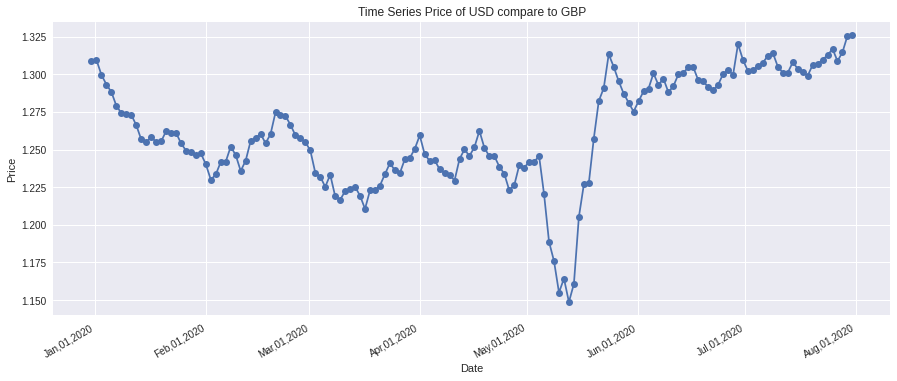

In [293]:
# Plotted prices and dates
# Notice how the dates start and end

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

In [294]:
# print(price)
test = np.array(dataset['total_deaths'])
# print(test)
price.shape
# test.shape
test = np.array(dataset['total_deaths'])
list_arr = np.array(test)
reversed_arr = list_arr[::-1]
reversed_arr.shape
price.shape

(154,)

In [295]:
# Adds the accumulative deaths every day of a country
# Problem – This needs to be sorted from the end since the way out data is set up - can this be made more efficient?
total_us_deaths = dataset['total_deaths']
list_arr = np.array(total_us_deaths)
reversed_arr = list_arr[::-1]
newDay = 0
day = []
for currentday in reversed_arr:
   newDay = currentday + newDay
   day.append(newDay)


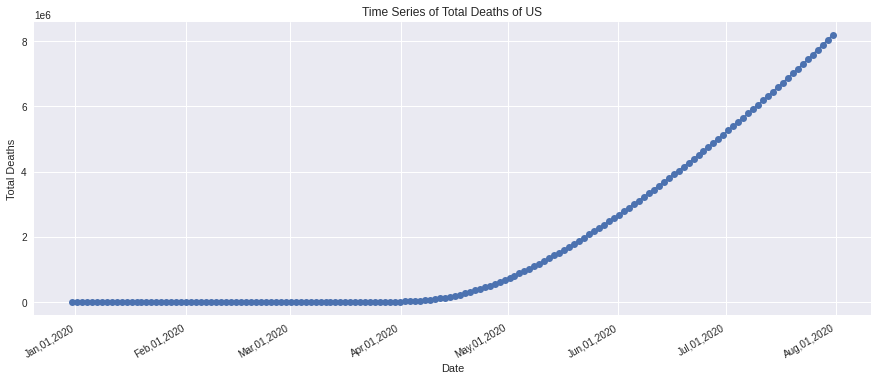

In [296]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_deaths = np.array(day)
plt.plot_date(dates,us_deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)



In [297]:
test.shape

(154,)

In [298]:
price.shape

(154,)

In [299]:
# Problem: Why is it showing up NAN in index 149,150,151?
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
death_frame = pd.DataFrame(np.concatenate([day]), columns= ["Total_Deaths_US"])

price_frame.append(death_frame)

,Price,Total_Deaths_US
0,1.3090,NaN
1,1.3095,NaN
2,1.2996,NaN
3,1.2932,NaN
4,1.2882,NaN
...,...,...
149,NaN,7590585.0
150,NaN,7738596.0
151,NaN,7887852.0
152,NaN,8038565.0


# Normalisation of Features

In [300]:
# Working Normalised method!!
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
# 8 decimal: readable formate:
# val = [print("{:.8f}".format(float(x)))for x in normalisation_us_deaths]

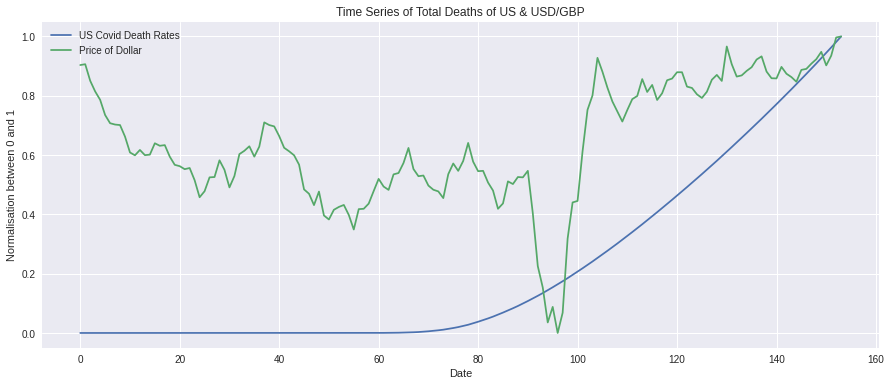

In [301]:
import matplotlib.pyplot as plt
plt.title('Time Series of Total Deaths of US & USD/GBP')
plt.plot(normalisation_us_deaths,label="US Covid Death Rates")
plt.plot(normalisation_price, label="Price of Dollar")
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.legend() 
plt.show()

# Preprocessing the Data - Train, Validation & Test


In [302]:
# Death Rates | Price of dollar
new_dataset = np.hstack((normalisation_us_deaths,normalisation_price))

In [303]:
# Test, Validation, Train 
# This should be ordered in respect to date – not cross validation or random seed
# We are going to divide our data based on date because the next data is always dependent on the previous data
# 65% of the total length of my datadrame
# 35% test size/ validation
training_size = int(len(new_dataset)*0.65)
test_size = (len(new_dataset)-training_size)//2 # // Rounds down
train_data, valset_data, test_data = new_dataset[0:training_size], new_dataset[training_size:(training_size + test_size)],new_dataset[(training_size + test_size):]
print(train_data.shape)
print(valset_data.shape)
print(test_data.shape)

(100, 2)
(27, 2)
(27, 2)


In [304]:
print(valset_data[:4])

[[0.20692559 0.44532131]
 [0.21814829 0.61217587]
 [0.22955632 0.75253664]
 [0.24111855 0.80101466]]


In [305]:
training_size, test_size

(100, 27)

In [306]:
len(train_data), len(test_data)

(100, 27)

In [307]:
# train_data

In [308]:
# Go over what this method does
# Convert an array of values into a dataset matrix
# time_step = how many previous days you have to consider before making a prediction. = 1 passing by ref
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  # len(dataset) = 154 - 7 = 147 -1 (guarentees 8th datapoint)
  # for i(starting point of dataset), i in range 146
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step)]  # i=0 : i + 7
    dataX.append(a)
    y = dataset[i + time_step][1] 
    dataY.append(y)
  return np.array(dataX), np.array(dataY)


In [309]:
# Weekly_timestep means taking in 7 days of features at a time 
weekly_timestep = 7
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_val, Y_val = create_dataset(valset_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)



In [310]:
print(X_test.shape), print(Y_test.shape)
# Finished preprocessing the data

(19, 7, 2)
(19,)


(None, None)

# Stacked LSTM Model

In [311]:
# Create the stacked LSTM model
# One LSTM after the other
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
def lstm_model(lr_rate, hidden_layer, optimizer_one):
  # we want input_tensor to be a single data point
  model = Sequential()
  opt = None
  if optimizer_one == 'adam':
   opt = keras.optimizers.Adam(learning_rate=lr_rate)
  elif optimizer_one == 'sgd':
   opt = keras.optimizers.SGD(learning_rate=lr_rate)
  else:
   opt = keras.optimizers.Adamax(learning_rate=lr_rate)
  model.add(InputLayer(input_shape=(7,2)))
  model.add(LSTM(hidden_layer,return_sequences=True))
  model.add(LSTM(hidden_layer, return_sequences=True))
  model.add(LSTM(hidden_layer))
  model.add(Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer=opt)
  return model

  

## Hyperparameter Tuning


*   Optimizers:
[Overview of different Optimizers for neural networks](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3#:~:text=Adagrad%20eliminates%20the%20need%20to,is%20no%20longer%20able%20learning.)
*   [Conceptual Guide for HP Tuning](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35)
*   [Consider this for Grid Search & Random Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)
*   [And this](https://stackoverflow.com/questions/58137140/randomizedsearchcv-with-keras-lstm-regression)
![Grid Search & Random Search](https://miro.medium.com/max/1200/1*ZTlQm_WRcrNqL-nLnx6GJA.png)



## Grid Search

*   We must choose candidates for good hidden layers and optimizers. Then plot a comparison.
*   List of optimizers: 
*   optimizers = ['SGD', 'RMSprop','adam','adagrad', 'adadelta', 'adamax','nadam', 'ftrl']
*   Callbacks: Restores best weights that is going to give u best model 
*   Consider changing batch size: slower the batch_size better training, because small dataset




In [312]:
hidden_layer_list = [15, 30]
best_hidden_layer = 1
optimizer_list = ['adam', 'adamax']
best_optimizer = 'adam'
learning_rate_list = [3e-3, 3e-4]
best_learning_rate = 3e-3
least_loss = 1

for each_hidden_layer in hidden_layer_list:
  for each_optimizer in optimizer_list:
    for each_learning_rate in learning_rate_list:
      our_model = lstm_model(each_learning_rate, each_hidden_layer, each_optimizer)
      our_model.fit(X_train, Y_train, 
                validation_data= 
                (X_val, Y_val)
                , epochs=100,batch_size=10,verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
      loss = our_model.evaluate(X_test, Y_test)
      if loss < least_loss:
          least_loss = loss
          best_learning_rate = each_learning_rate
          best_optimizer = each_optimizer
          best_hidden_layer = each_hidden_layer
  print(least_loss, best_learning_rate, best_optimizer, best_hidden_layer)

Epoch 1/100
10/10 [==============================] - 1s 90ms/step - loss: 0.1638 - val_loss: 0.0387
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0320 - val_loss: 0.0538
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0223 - val_loss: 0.0768
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0185 - val_loss: 0.0347
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0154 - val_loss: 0.0702
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0157 - val_loss: 0.0583
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0619
Epoch 1/100
10/10 [==============================] - 1s 92ms/step - loss: 0.2480 - val_loss: 0.6006
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 0.2202 - val_loss: 0.5515
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 0.1913 - val_loss: 0.4991
Epoch 4/100
10/10 [==========

# Best Model Prediction

In [313]:
best_param_model = lstm_model(best_learning_rate, best_hidden_layer, best_optimizer)
best_param_model.fit(X_train, Y_train, epochs=160,batch_size=10,verbose=1)
loss = best_param_model.evaluate(X_test, Y_test) # all results from dictionary


Epoch 1/160
10/10 [==============================] - 0s 6ms/step - loss: 0.1076
Epoch 2/160
10/10 [==============================] - 0s 5ms/step - loss: 0.0242
Epoch 3/160
10/10 [==============================] - 0s 6ms/step - loss: 0.0157
Epoch 4/160
10/10 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 5/160
10/10 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 6/160
10/10 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 7/160
10/10 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 8/160
10/10 [==============================] - 0s 8ms/step - loss: 0.0115
Epoch 9/160
10/10 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 10/160
10/10 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 11/160
10/10 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 12/160
10/10 [==============================] - 0s 7ms/step - loss: 0.0099
Epoch 13/160
10/10 [=================

In [314]:
# Prediction and check performance metric
train_predict = best_param_model.predict(X_train)
test_predict = best_param_model.predict(X_test)
train_predict.shape
train_predict.shape

(92, 1)

In [315]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
# print(train_predict, test_predict)

In [316]:
test_predict

array([[1.0074418 ],
       [1.0035846 ],
       [1.0051701 ],
       [1.0042672 ],
       [1.0035353 ],
       [1.0020782 ],
       [0.9991992 ],
       [0.9957014 ],
       [0.9940499 ],
       [0.99437803],
       [0.99413836],
       [0.9926762 ],
       [0.99044675],
       [0.9896539 ],
       [0.98956215],
       [0.98941267],
       [0.98839456],
       [0.9872806 ],
       [0.9859503 ]], dtype=float32)

# Performance Metric


*   Mean square error: Measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value
*   Kullback-Leibler divergence, which is also called relative entropy, is a measure of the difference between two probability distributions P and Q where P is the distribution of the observation that we want to see how much it differs from the average prior distribution Q.




In [317]:
# Calculate the RMSE performance metrics
# Output for the train dataset
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))

0.7389332933975417

In [318]:
# Use testing
math.sqrt(mean_squared_error(Y_test, test_predict))

0.10278195189328905

In [319]:
# Evaluating: How well is model performing 
# Probability distribution rather than time series
# Tensorflow??
# KL Divergence
# Consider this for evaluation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence
# kl divergence measures difference between 2 probability distributions, 
# measure of what i am predicting and what should have been predicting

# Actual Data, Train Prediction & Test Prediction data

(154, 2)
(154, 2)


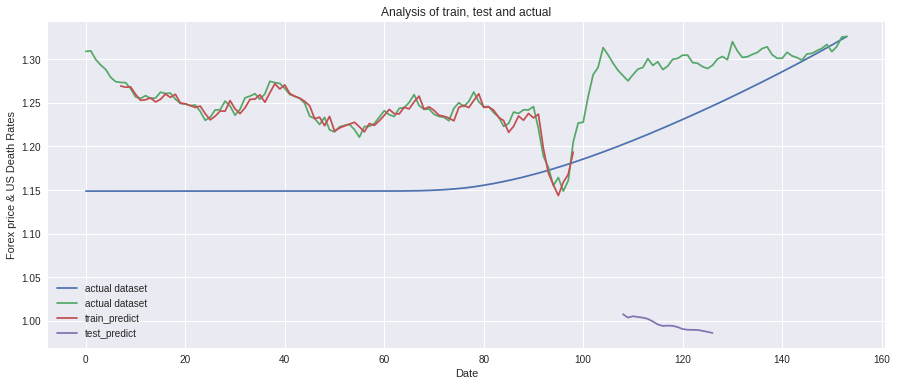

In [320]:
# Problem: testPredictPlot[len(train_predict)+(look_back*2)+2: (training_size + test_size)] = test_predict

# Taking in the 7 

look_back = 7

# empty_like: Return a new array with the same shape and type as a given array.
# np.nan: Replect all with nan? What does this mean?
# What does this do?? 7: predict.length() + 7, :

trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)

# empty_like: Return a new array with the same shape and type as a given array.
# np.nan: Replect all with nan? What does this mean?
# Dont understand what this is doing
# What does this do?? predict.length() + (7*2) +2 :(training_size + test_size)] = test_predict

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan

testPredictPlot[len(train_predict)+(look_back*2)+2: (training_size + test_size)] = test_predict
# new_dataset[training_size:(training_size + test_size)]
print(testPredictPlot.shape)

# Plot baseline and predictions
plt.title('Analysis of train, test and actual')
plt.plot(scaler.inverse_transform(new_dataset), label="actual dataset")

trainPredictPlot = [item[1] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict")

testPredictPlot = [item[1] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")

# as you can see th test data and train is divided because we want to test after a specific day
plt.ylabel('Forex price & US Death Rates')
plt.xlabel('Date')
plt.legend()
plt.show()
# Printing 2 actual_dataset, train_predict, test_predict because 2 input layers

# Custom 4 day prediction

*   Training train data to predict future days and evaluating the accuracy on validation data.
*   Training train data to predict future days, no way of evaluating however this can tell us what is likely to occur.
*   Using last 7 days of training data to predict the future custom days(4). 



In [321]:
# Taking the last 7 days of test
# print(test_data[80:])
# is this supposed to be test or train_data
X_input=test_data[100:].reshape(1,-1)
print(X_input)
X_input.shape

temp_input = train_data[-7:]
temp_input



[]


array([[0.13458041, 0.15332582],
       [0.14429003, 0.03551297],
       [0.1541408 , 0.08793687],
       [0.16419948, 0.        ],
       [0.17447133, 0.06820744],
       [0.18495965, 0.31848929],
       [0.19589434, 0.44024803]])

In [322]:
# Demonstrate prediction for the next 4 days:

# Step 1. 7 days of feature = temp_input taken from the last 7 days of the training set
# Step 2  i is the day you are on and we want to predict 4 days: 0,1,2,3 (4 days)
# Step 3. Predict the 8th day on each of the 7 days,
# Step 4. Add this new predicted day to the list
# Step 5. Because we are now taking in the last 7 days + the new predicted value, the list is now size 8  
# Step 6. In order to take in 7 days at a time, we shift 1 to the right.
# Step 7. We reassign the X_train to the new 7 days
# Step 8. We predict the 8th day of the 7 days and continue the process
# Step 9. We then add the 8th day to the output list
# Step 10. We keep track of the 4 days by incrementing by i at the end-> i = i+1
# Step 11. Once we have predicted the 4 days, we return the list of 4 day values.

from numpy import array
custom_day = 4
lst_output=[]
n_steps=7
i=0
X_input = temp_input
# print(X_input)
while(i<custom_day):
  if(len(temp_input)>7):
    # print(temp_input)  
    X_input=array(temp_input[1:])
    # print("{} day input {}".format(i,X_input))
    # Correct input shape (1,7,2)
    X_input=X_input.reshape((1,n_steps,2))
    # Prediction of X_input
    print(X_input)
    Y_hat = best_param_model.predict(X_input)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    temp_input=temp_input[1:]
    lst_output.append(Y_hat[0][0])
    i=i+1
  else:
    X_input=X_input.reshape((1,n_steps,2))
    print(X_input)
    Y_hat = best_param_model.predict(X_input, verbose=0)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    lst_output.append(Y_hat[0][0])
    i=i+1
# [0.039997526, 0.035484765, 0.029113937, 0.025276443]
# Print the predicted forex price for the next 4 days 
print(lst_output)

[[[0.13458041 0.15332582]
  [0.14429003 0.03551297]
  [0.1541408  0.08793687]
  [0.16419948 0.        ]
  [0.17447133 0.06820744]
  [0.18495965 0.31848929]
  [0.19589434 0.44024803]]]
[[[0.15332582 0.14429003]
  [0.03551297 0.1541408 ]
  [0.08793687 0.16419948]
  [0.         0.17447133]
  [0.06820744 0.18495965]
  [0.31848929 0.19589434]
  [0.44024803 0.61672008]]]
[[[0.14429003 0.03551297]
  [0.1541408  0.08793687]
  [0.16419948 0.        ]
  [0.17447133 0.06820744]
  [0.18495965 0.31848929]
  [0.19589434 0.44024803]
  [0.61672008 0.71685249]]]
[[[0.03551297 0.1541408 ]
  [0.08793687 0.16419948]
  [0.         0.17447133]
  [0.06820744 0.18495965]
  [0.31848929 0.19589434]
  [0.44024803 0.61672008]
  [0.71685249 0.78738189]]]
[0.6167201, 0.7168525, 0.7873819, 0.68703246]


### Plotting evaluation on graph. Training output versus first 4 days of the validation data.

[0.6167201  0.7168525  0.7873819  0.68703246]
[0.4453213077790297, 0.6121758737316796, 0.7525366403607663, 0.8010146561443054]


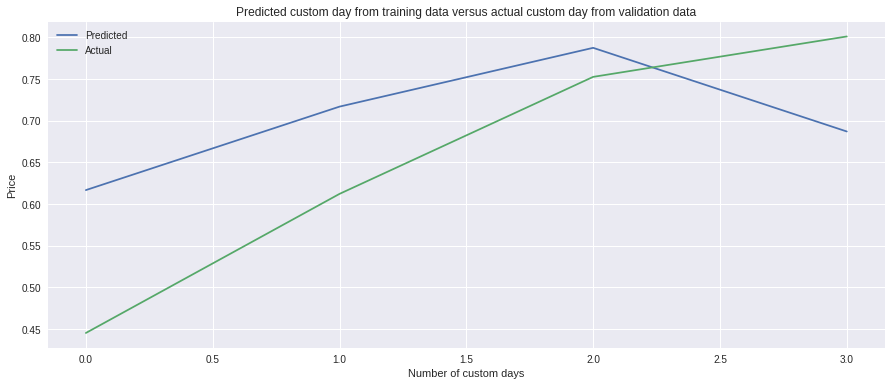

In [323]:
# Custom day plotted
day_new = custom_day-1

# Predicted 4 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted")
# plt.plot(day_new, scaler.inverse_transform([custom_day_prediction]))

# Actual 4 days from validation
# Plot and label
# Transform back to original value before normalised
val_data = [item[1] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
print(custom_day_validation)
plt.plot(custom_day_validation, label="Actual")
# plt.plot(day_new, scaler.inverse_transform([custom_day_validation]))

# Information
plt.title('Predicted custom day from training data versus actual custom day from validation data')
plt.xlabel('Number of custom days')
plt.ylabel('Price')
plt.legend()
plt.show()


# our_model = [0.74404275 0.8052977  0.7691769  0.89058316] 
# [0.6725929 0.6040678 0.6569952 0.6451826]
# [0.6725929 0.6040678 0.6569952 0.6451826]

[0.6167201  0.7168525  0.7873819  0.68703246]


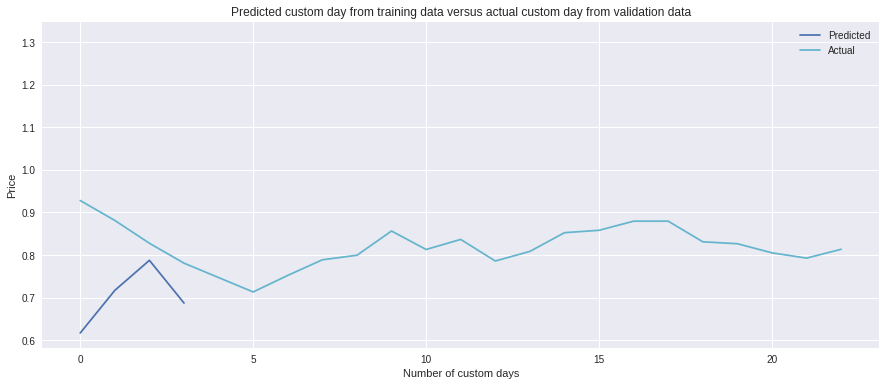

In [324]:
# Connect what we got as a result to the future
day_new = custom_day-1

# Predicted 4 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted")
plt.plot(day_new, scaler.inverse_transform([custom_day_prediction]))

# Actual 4 days from validation
# Plot and label
# Transform back to original value before normalised
# Start on 4 instead
val_data = [item[1] for item in valset_data] 
custom_day_validation = val_data[custom_day:]
plt.plot(custom_day_validation, label="Actual")
plt.plot(day_new, scaler.inverse_transform([custom_day_validation]))

# Information
plt.title('Predicted custom day from training data versus actual custom day from validation data')
plt.xlabel('Number of custom days')
plt.ylabel('Price')
plt.legend()
plt.show()



[0.6167201  0.7168525  0.7873819  0.68703246]
[0.4453213077790297, 0.6121758737316796, 0.7525366403607663, 0.8010146561443054]


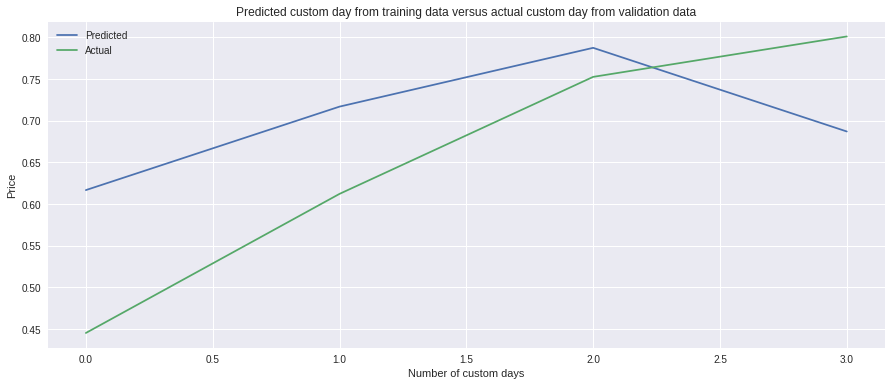

In [325]:
# Custom day plotted
day_new = custom_day-1

# Predicted 4 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted")
# plt.plot(day_new, scaler.inverse_transform([custom_day_prediction]))

# Actual 4 days from validation
# Plot and label
# Transform back to original value before normalised
val_data = [item[1] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
print(custom_day_validation)
plt.plot(custom_day_validation, label="Actual")
# plt.plot(day_new, scaler.inverse_transform([custom_day_validation]))

# Information
plt.title('Predicted custom day from training data versus actual custom day from validation data')
plt.xlabel('Number of custom days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [326]:
# What we have:
# day_new=np.arange(1,8)
# print(day_new)
# What we want to predict:
# day_pred=np.arange(8,12)
# print(day_pred)

# Conclusion and next steps
We explored the LSTM algorithms:

*   List item
*   List item


In conclusion it seems that ..